# **Multilayer Perceptron: Market Timing in AAPL Stock**

**Goal**: To design a strategy that times the return of Apple Stock using MLP network that aims to predict whether the future return of AAPL is positive or negtaive.

**1. Data**

In [20]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import tensorflow as ts 

from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [13]:
df = yf.download("AAPL", start="1980-01-01", end="2022-04-11")

df["Ret"] = df["Close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ret
10415,2022-04-04,174.570007,178.490005,174.440002,178.440002,175.787781,76468400,0.023693
10416,2022-04-05,177.500000,178.300003,174.419998,175.059998,172.458054,73401800,-0.018942
10417,2022-04-06,172.360001,173.630005,170.130005,171.830002,169.276047,89058800,-0.018451
10418,2022-04-07,171.160004,173.360001,169.850006,172.139999,169.581451,77594700,0.001804
10419,2022-04-08,171.779999,171.779999,169.199997,170.089996,167.561905,76575500,-0.011909


**Inputs and Outputs**

In [14]:
df["Ret25_i"] = df[name].rolling(25).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret60_i"] = df[name].rolling(60).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret90_i"] = df[name].rolling(90).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret120_i"] = df[name].rolling(120).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret240_i"] = df[name].rolling(240).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))

del df["Date"]
del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]

df = df.dropna()
df.tail(10)

,Adj Close,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i
10410,172.990005,0.005037,0.053177,-0.004083,0.167228,0.236556,0.294444
10411,176.300110,0.019134,0.090150,0.018587,0.169876,0.249413,0.316171
10412,175.127777,-0.006650,0.109386,-0.013065,0.134641,0.233641,0.304416
10413,172.014740,-0.017776,0.074899,-0.018149,0.099848,0.218551,0.299455
10414,171.719193,-0.001718,0.060206,0.006735,0.095198,0.217461,0.294793
10415,175.787781,0.023693,0.082274,0.047131,0.116489,0.250331,0.330280
10416,172.458054,-0.018942,0.074954,0.027191,0.094239,0.235592,0.293184
10417,169.276047,-0.018451,0.035893,0.008619,0.107483,0.196832,0.271693
10418,169.581451,0.001804,0.039680,-0.006359,0.087396,0.191113,0.275958
10419,167.561905,-0.011909,0.046183,-0.020837,0.043885,0.167355,0.270060


**Defining the output: Classification**

- Defining output labels with the focus on the +120(trading) days return for Apple stock. The aim is to predict whether, on a given time t, the return of AAPL from time t to t+120 days will be positive or negative - zero return, although unlikely, will also be classified as a negative return.
- Therefore, we first investigate, at a given time t, what would be the 120-day return. Then, we calculate our output variable, keeping in that we'll be running a classifcation task, and, hence, we need to convert our output variables to a 0, 1, variable (0 for negative 120 days return, and 1 for positive).

In [15]:
df["Ret120"] = df["Ret120_i"].shift(-120)
df["Output"] = df["Ret120"] > 0
df["Output"] = df["Output"].astype(int)
del df["Ret120"]
df = df.dropna()
df.tail()

C:\Users\Asus\AppData\Local\Temp\ipykernel_9428\745173308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ret120"] = df["Ret120_i"].shift(-120)
C:\Users\Asus\AppData\Local\Temp\ipykernel_9428\745173308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Output"] = df["Ret120"] > 0
C:\Users\Asus\AppData\Local\Temp\ipykernel_9428\745173308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,Adj Close,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
10415,175.787781,0.023693,0.082274,0.047131,0.116489,0.250331,0.330280,0
10416,172.458054,-0.018942,0.074954,0.027191,0.094239,0.235592,0.293184,0
10417,169.276047,-0.018451,0.035893,0.008619,0.107483,0.196832,0.271693,0
10418,169.581451,0.001804,0.039680,-0.006359,0.087396,0.191113,0.275958,0
10419,167.561905,-0.011909,0.046183,-0.020837,0.043885,0.167355,0.270060,0


In [16]:
df.describe()

,Adj Close,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
count,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000,10180.000000
mean,13.631870,0.001156,0.028769,0.069319,0.103529,0.136820,0.269300,0.700688
std,30.181512,0.028195,0.141440,0.226857,0.279749,0.321892,0.448599,0.457979
min,0.037815,-0.518692,-0.940299,-1.151643,-1.040123,-1.048316,-0.902589,0.000000
25%,0.244078,-0.012876,-0.049469,-0.050549,-0.049196,-0.047057,-0.057184,0.000000
50%,0.403020,0.000000,0.034809,0.081938,0.117454,0.155192,0.286294,1.000000
75%,12.961507,0.014601,0.114231,0.209767,0.262165,0.311400,0.560896,1.000000
max,179.076584,0.332280,0.882472,0.892261,1.141606,1.301160,1.782617,1.000000


**2. Train-Test Samples and Scaling**

- We will take 20% of observations and devote them to testing, while 80% will be used for training the model

In [17]:
ts = int(0.2 * len(df)) # Number of observations in the test sample
split_time = len(df) - ts  # From this data we are in the test sample
test_time = df.iloc[split_time:, 0:1].values  # Keep the test sample dates
Ret_vector = df.iloc[split_time:, 1:2].values 
df.tail()

,Adj Close,Ret,Ret25_i,Ret60_i,Ret90_i,Ret120_i,Ret240_i,Output
10415,175.787781,0.023693,0.082274,0.047131,0.116489,0.250331,0.330280,0
10416,172.458054,-0.018942,0.074954,0.027191,0.094239,0.235592,0.293184,0
10417,169.276047,-0.018451,0.035893,0.008619,0.107483,0.196832,0.271693,0
10418,169.581451,0.001804,0.039680,-0.006359,0.087396,0.191113,0.275958,0
10419,167.561905,-0.011909,0.046183,-0.020837,0.043885,0.167355,0.270060,0


- Next, we use sklearn to formally define the input and output matrices for training (X_train and y_train) and test (X_test and y_test).

In [19]:
Xdf, ydf = df.iloc[:, 2:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=True
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8144, 5) (2036, 5) (8144,) (2036,)


**2. Model Training**

**Scaling**: We use scaled data by taking prices that adjust for any dividends. 

**Model and Training**: We use 3 hidden layers with 25, 15, 10 units respectively, and a final single-unit output layer. 
- All hidden layers use a ReLU activation function, whereas the output layer uses sigmoid activation function. 
- **Dropou Layer** - after each hidden layer. Dropout randomly sets some units of a hidden layer to zero. We set n_dropout = 0.2 to shut down 20% of the units in the layer. 
- **Loss function**  We use a binary cross-entropy that is essentially a log-likelihood.

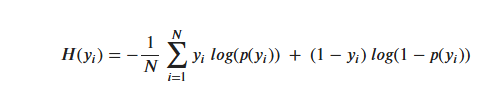

- **Metric for loss function** - Binary accuracy.

In [21]:
tf.keras.backend.clear_session() # We clear the backend to reset the random seed process
tf.random.set_seed(1234) # A random seed so that results obtained are somewhat replicable. 

act_fun = 'relu'
hp_units = 25
hp_units_2 = 15 
hp_units_3 = 10
n_dropout = 0.2 

